In [1]:
import pandas as pd
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import numpy as np
from matplotlib import colormaps

from mri_data import file_manager as fm

In [31]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
work_home = drive_root / "srs-9/longitudinal"
data_dir = Path("/home/srs-9/Projects/ms_mri/analysis/thalamus/data0")
date_format = "%Y%m%d"
fig_path = Path("/home/srs-9/Projects/ms_mri/choroid_thalamus_project/figures")

choroid_volumes = pd.read_csv("/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv",
                              index_col="subid").dropna()

thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv("/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", 
                              index_col="index")

with open(dataroot / "subject-sessions-longit.json", 'r') as f:
    subject_sessions = json.load(f)

df_dists = pd.read_csv(data_dir / "centroid-SDT.csv", index_col="subid")
ventricle_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/choroid_thalamus_project/sub1001-centroid-ventricle-sdt.csv")
# df_dists.loc[9999, :] = ventricle_dists['dist'].tolist()

df_clinical = pd.read_csv("/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid")

viridis = colormaps['viridis'].resampled(20)

In [32]:
def get_subject_data(subid):
    sessions = sorted(subject_sessions[subid])
    work_dir = work_home / f"sub{subid}"

    session_volumes = defaultdict(list)
    # just copy first and last to speed things up
    sessions = sorted(sessions)
    sessions = [sessions[0], sessions[-1]]
    for sesid in sessions:
        ses_dataL = pd.read_csv(work_dir / "left" / f"hipsthomas_vols_jacobians-{sesid}.csv", index_col="struct")
        ses_dataR = pd.read_csv(work_dir / "right" / f"hipsthomas_vols_jacobians-{sesid}.csv", index_col="struct")
        vols = []
        for i in ses_dataL.index:
            left_vol = ses_dataL.loc[i, 'volumes'] / np.exp(ses_dataL.loc[i, 'jac_det'])
            right_vol = ses_dataR.loc[i, 'volumes'] / np.exp(ses_dataR.loc[i, 'jac_det'])
            vols.append(left_vol+right_vol)
        session_volumes[sesid] = vols

    df = pd.DataFrame(session_volumes, index=ses_dataL.index)
    data = pd.DataFrame({}, index=df.index)
    data['dist'] = df_dists.loc[int(subid), :].tolist()
    # data['dist'] = df_dists.loc[9999, :].tolist()
    changes = [(row[sessions[-1]] - row[sessions[0]])/row[sessions[0]] for _,row in df.iterrows()]
    data['change'] = changes

    delta = datetime.strptime(str(df.columns[-1]), date_format) - datetime.strptime(str(df.columns[0]), date_format)
    t_delta = delta.days

    choroid_vol = choroid_volumes.loc[int(subid), 'choroid_volume']
    cp_percentile = stats.percentileofscore(choroid_volumes['choroid_volume'], choroid_vol)

    return {'data': data, 't_delta': t_delta, 'choroid_percentile': cp_percentile}

In [44]:
all_subjects = [1001, 1107, 1125, 1161, 1198, 1218, 1527, 1376, 2075, 1023, 1038, 1098, 1326, 2195, 1076, 1042, 1508, 1071, 1241, 1003, 1301]
subjects = [subid for subid in all_subjects if df_clinical.loc[subid, "dz_type5"] == "PMS"]
# subjects = all_subjects
# subjects = [1001, 1107, 1125, 1161, 1198, 1218, 1326, 1527, 2195, 1376]
# subjects = [2195]
# subjects = [1326]
subjects = [str(sub) for sub in subjects]
data_structs = {}
for subid in subjects:
    data_structs[subid] = get_subject_data(subid)

Text(4, 0, 'R2=0.01\np=0.72')

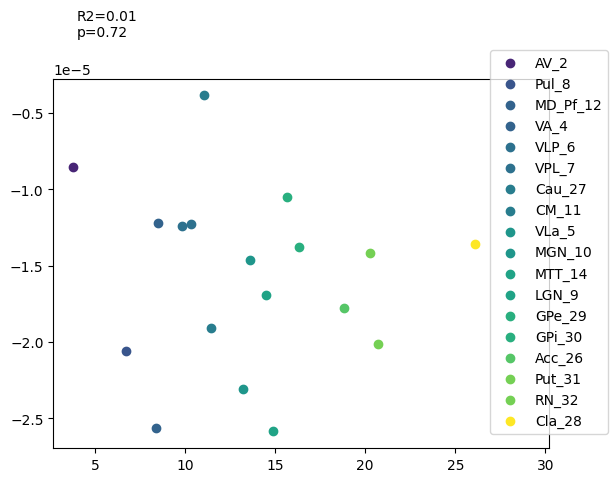

In [45]:
all_changes = np.zeros((len(thalamic_nuclei), len(subjects)))
all_changes = np.zeros((19, len(subjects)))
for i, subid in enumerate(subjects):
    data_struct = data_structs[str(subid)]
    data = data_struct['data']
    # data = data.loc[thalamic_nuclei, :]
    all_changes[:, i] = data['change'] / data_struct['t_delta']

plot_data = data.copy()
plot_data['dist'] = df_dists.mean(axis=0).to_list()
plot_data['mean_change'] = np.mean(all_changes, axis=1)
plot_data['struct'] = hips_thomas_ref['struct']
plot_data.sort_values(by="dist", inplace=True)

plot_data = plot_data.loc[plot_data.index[~plot_data.index.isin([13])], :]
fig, axes = plt.subplots(1)
for i, row in plot_data.iterrows():
    c = plot_data.loc[i, 'dist'] / plot_data['dist'].max()
    axes.scatter(plot_data.loc[i, 'dist'], plot_data.loc[i, 'mean_change'], color=viridis(c), label=plot_data.loc[i, 'struct'])

xlims = axes.get_xlim()
axes.set_xbound([xlims[0], xlims[1]+3])
fig.legend(loc=(0.8,0.1))

slope, intercept, r_value, p_value, std_err = stats.linregress(plot_data['dist'], plot_data['mean_change'])

text = "R2={:0.2f}\np={:0.2f}".format(r_value**2, p_value)
axes.text(4, 0, text)

In [35]:
check = df_dists.mean(axis=0)

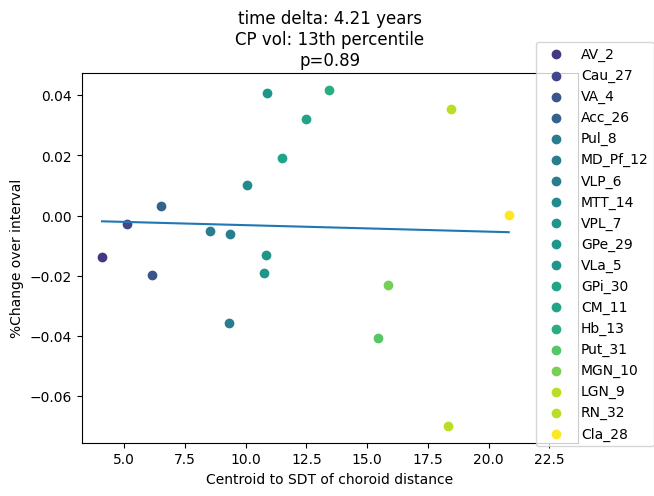

In [66]:
subjects = [1098]
for subid in subjects:
    suffix = "all"
    data_struct = data_structs[str(subid)]
    data = data_struct['data']
    # data = data.loc[thalamic_nuclei, :]
    data = data.sort_values(by="dist")

    fig, axes = plt.subplots(1)
    for i, row in data.iterrows():
        c = row['dist'] / data['dist'].max()
        axes.scatter(row['dist'], row['change'], color=viridis(c), label=hips_thomas_ref.loc[i,'struct'])

    # plt.scatter(data.loc[thalamic_nuclei, 'dist'], data.loc[thalamic_nuclei, 'change'], 
    #             label=hips_thomas_ref.loc[thalamic_nuclei, 'struct'])

    axes.set_ylabel(r"%Change over interval")
    axes.set_xlabel("Centroid to SDT of choroid distance")

    slope, intercept, r, p, se = stats.linregress(data['dist'], data['change'])
    x = np.linspace(data['dist'].min(), data['dist'].max(), 10)
    y = intercept + slope*x
    plt.plot(x, y)

    title = "time delta: {:.2f} years\nCP vol: {:.0f}th percentile\np={:.2f}".format(data_struct['t_delta']/365,
                                                                        data_struct['choroid_percentile'],
                                                                        p)
    axes.set_title(title)
    # plt.plot([data['dist'].min(), data['dist'].max()], [0, 0], '--')

    xlims = axes.get_xlim()
    axes.set_xbound([xlims[0], xlims[1]+2])
    fig.legend(loc=(0.82,0.1))


    # plt.savefig(fig_path / f"sub{subid}_{suffix}.png", dpi=300, pad_inches=0.2)

In [189]:
hips_thomas_ref.loc[thalamic_nuclei, 'struct']

index
2         AV_2
4         VA_4
5        VLa_5
6        VLP_6
7        VPL_7
8        Pul_8
9        LGN_9
10      MGN_10
11       CM_11
12    MD_Pf_12
Name: struct, dtype: object

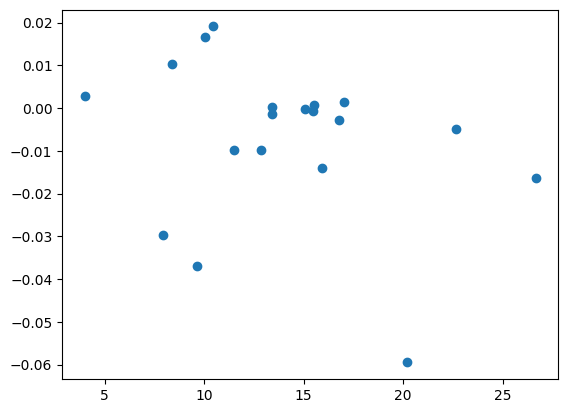

In [134]:
date_format = "%Y%m%d"
time_pts = [0]
for pt in df.columns[1:]:
    delta = datetime.strptime(str(pt), date_format) - datetime.strptime(str(df.columns[0]), date_format)
    time_pts.append(delta.days)

time_pts = np.array(time_pts)

slopes = pd.DataFrame({}, index=df.index)
for struct, row in df.iterrows():
    vols = np.array(row)
    slope, intercept, r_value, p_value, std_err = stats.linregress(time_pts, vols)
    slopes.loc[struct, 'slope'] = slope

plt.scatter(df_dists.loc[int(subid), :], slopes['slope'])